# Use knowledge base from Semantic Scholar

In [58]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\data_collection\output_100.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
df = df[df['abstract'].notna()]

# print out the DataFrame to verify
print(df.head())

                                    paperId  \
0  f15a2d21309f429fbec688b8aee5c7bdb66b8f40   
3  5b190c555003e154bb9038844899014425236273   
4  e24d6d882c78389a9c356b87ac46e065087549cf   
6  9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
7  154b9fd69570539e90f51e1b19db944713d3bfdc   

                                                 url  \
0  https://www.semanticscholar.org/paper/f15a2d21...   
3  https://www.semanticscholar.org/paper/5b190c55...   
4  https://www.semanticscholar.org/paper/e24d6d88...   
6  https://www.semanticscholar.org/paper/9496966a...   
7  https://www.semanticscholar.org/paper/154b9fd6...   

                                               title  \
0  Renewable-integrated flexible carbon capture: ...   
3  Carbon capture and conversion using metal-orga...   
4  Climate change mitigation potential of carbon ...   
6  Cooperative carbon capture and steam regenerat...   
7  A Guideline for Life Cycle Assessment of Carbo...   

                                           

In [17]:
import pandas as pd
import json

# load the data from your JSON file
with open(r'C:\Users\1kevi\Desktop\projects\Research\autoscious-carbon-capture\data_collection\output_50.json', 'r') as f:
    data = json.load(f)

# convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# remove rows with null abstracts
# df = df[df['abstract'].notna()]
# df = df[df['tldr'].notna()]

# print out the DataFrame to verify
print(df.head())

                                     paperId  \
3   5b190c555003e154bb9038844899014425236273   
4   e24d6d882c78389a9c356b87ac46e065087549cf   
6   9496966a27c7a9176ec0a8ff6a04781caa42b7bb   
12  cfa569019717301c352aabec292a8f4d3a261553   
20  7a2197144b3a1567e814ea35fd73bd85a698681f   

                                                  url  \
3   https://www.semanticscholar.org/paper/5b190c55...   
4   https://www.semanticscholar.org/paper/e24d6d88...   
6   https://www.semanticscholar.org/paper/9496966a...   
12  https://www.semanticscholar.org/paper/cfa56901...   
20  https://www.semanticscholar.org/paper/7a219714...   

                                                title  \
3   Carbon capture and conversion using metal-orga...   
4   Climate change mitigation potential of carbon ...   
6   Cooperative carbon capture and steam regenerat...   
12  Performance-Based Screening of Porous Material...   
20  In silico discovery of covalent organic framew...   

                         

In [3]:
# Get the first row of the DataFrame
first_row = df.iloc[0]
print(first_row)

paperId                   f15a2d21309f429fbec688b8aee5c7bdb66b8f40
url              https://www.semanticscholar.org/paper/f15a2d21...
title            Renewable-integrated flexible carbon capture: ...
abstract         To decarbonize electricity grids, CO2 capture ...
year                                                          2021
citationCount                                                   28
isOpenAccess                                                 False
fieldsOfStudy                              [Environmental Science]
embedding        {'model': 'specter@v0.1.1', 'vector': [-1.3025...
tldr                                                          None
Name: 0, dtype: object


In [26]:
# Get the shape of the DataFrame
num_rows, num_cols = df.shape
print(f"The dataframe has {num_rows} rows and {num_cols} columns.")


The dataframe has 59 rows and 10 columns.


# Generate a literature review using concepts (TLDRs)

In [11]:
# Have GPT3.5 generate a literature review of carbon capture using the TLDRs (significance)
%load_ext dotenv
%dotenv
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
import openai

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [12]:
# for bulk openai message, no stream
def chat_openai(prompt="Tell me to ask you a prompt", chat_history=[]):
    # define message conversation for model
    if chat_history:
        messages = chat_history
    else:
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
        ]
    messages.append({"role": "user", "content": prompt})

    # create the chat completion
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
    )
    text_answer = completion["choices"][0]["message"]["content"]

    # updated conversation history
    messages.append({"role": "assistant", "content": text_answer})

    return text_answer, messages

In [20]:
# Get 'tldr' column as a Series
tldr_series = df['tldr']

# Extract the 'text' from each 'tldr' dictionary in the Series
tldr_texts = [item['text'] if item is not None else None for item in tldr_series]


In [21]:
print(tldr_texts)

['This review provides a comprehensive account of significant progress in the design and synthesis of MOF-based materials, including MOFs, MOF composites and MOF derivatives, and their application to carbon capture and conversion.', 'This study shows that CCU has the technical potential to lead to a carbon-neutral chemical industry and decouple chemical production from fossil resources, reducing annual GHG emissions by up to 3.5 Gt CO2-eq in 2030.', 'A family of robust tetraamine-functionalized frameworks that retain cooperativity are reported, leading to the potential for exceptional efficiency in capturing CO2 under the extreme conditions relevant to natural gas flue emissions.', 'The objective of this work is to review the current status of this new approach to multiscale screening, discuss its potential and impact on the field of materials screening, and highlight the challenges that limit its application.', 'A genetic algorithm is developed to tune the charge equilibration method 

In [27]:
prompt = "I am a college student who is a beginner in carbon capture. Write a literature review of carbon capture using the TLDRs (significance) of papers: " + str(tldr_texts)

In [28]:
res = chat_openai(prompt)

In [29]:
res

('Carbon capture and conversion (CCU) has been identified as a potential solution to reduce global CO2 emissions. One way to achieve this is through the use of metal-organic framework-based materials (MOFs) for carbon capture. A comprehensive review of MOFs and their derivatives reveals significant progress in their design and synthesis. MOFs have great potential for application in CCU due to their high surface area, tunability, and selectivity.\n\nAnother study shows that CCU has technical potential to lead to a carbon-neutral chemical industry, reducing annual GHG emissions by up to 3.5 Gt CO2-eq by 2030. This could potentially decouple chemical production from fossil resources, crucial for mitigating climate change.\n\nA family of robust tetraamine-functionalized frameworks has been developed that effectively captures CO2 under extreme conditions. This opens up the potential for exceptional efficiency in CCU in natural gas flue emissions.\n\nThe use of genetic algorithms has facilit

# Generating a T-SNE Visualization of the knowledge base

In [59]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import textwrap
from adjustText import adjust_text

In [60]:
embeddings = np.vstack(df['embedding'].apply(lambda x: x['vector']))

In [61]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)


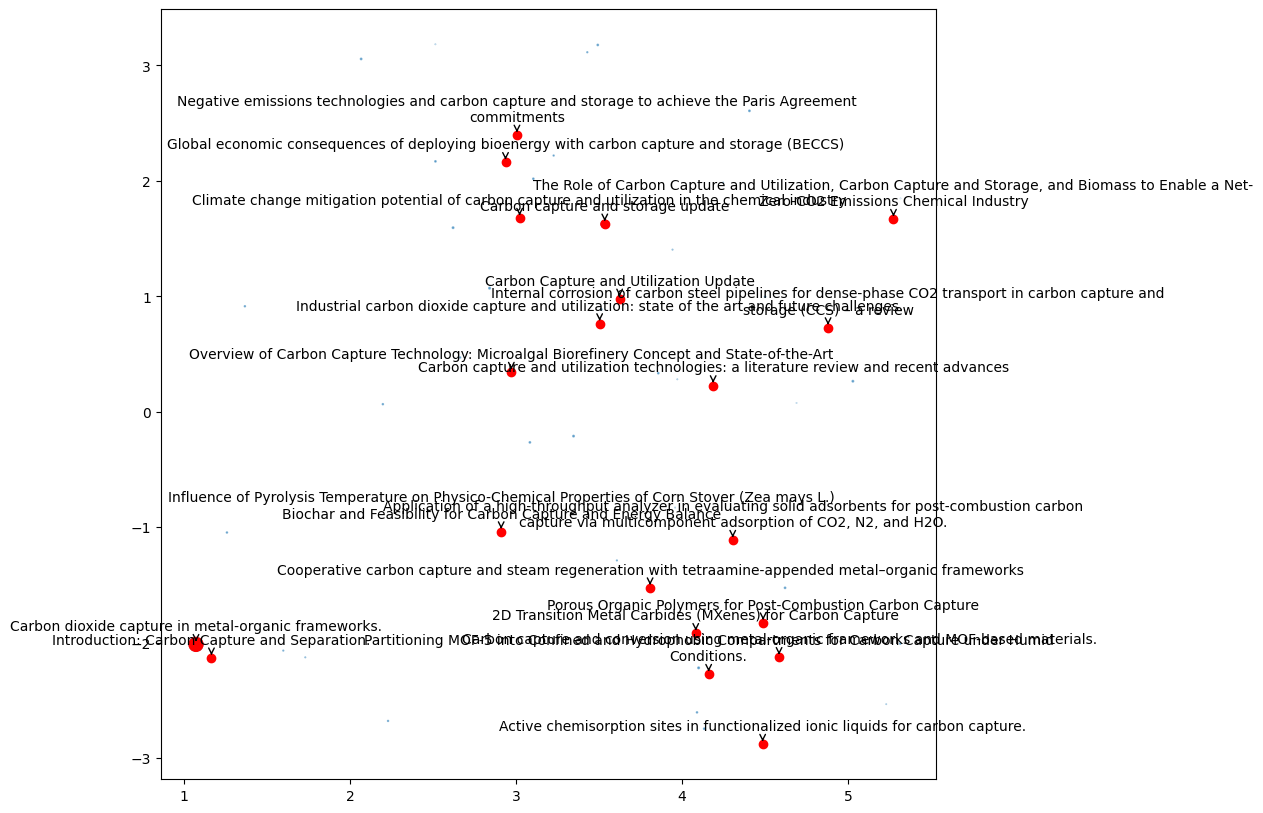

In [62]:
# Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
df['x'] = embeddings_2d[:, 0]
df['y'] = embeddings_2d[:, 1]
df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
df['citationCount_normalized'] = df['citationCount_normalized'] * 100  # Scale to a suitable range for scatter plot node sizes

# Sort the DataFrame based on citationCount and select the top 20
df_top20 = df.nlargest(20, 'citationCount')

# Create a scatter plot of all the points with node sizes based on normalized citationCount
plt.figure(figsize=(10, 10))
plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red', label='Top 20 papers')

# Prepare to add titles of the top 20 papers to the plot with text wrapping
texts = []
for i, row in df_top20.iterrows():
    title_wrapped = textwrap.fill(row['title'], width=100)  # Wrap text after 20 characters
    plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
    texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

In [70]:
# Exporting dataframe with T-SNE coordinates
df
df.drop('embedding', axis=1)
df.to_json('output_100_tsne.json', orient='records')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


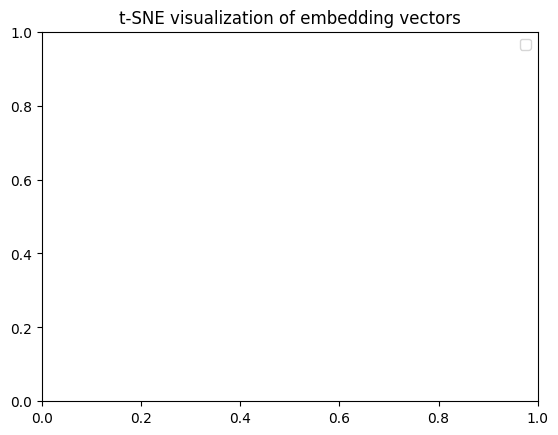

In [22]:
# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend()
# plt.show()

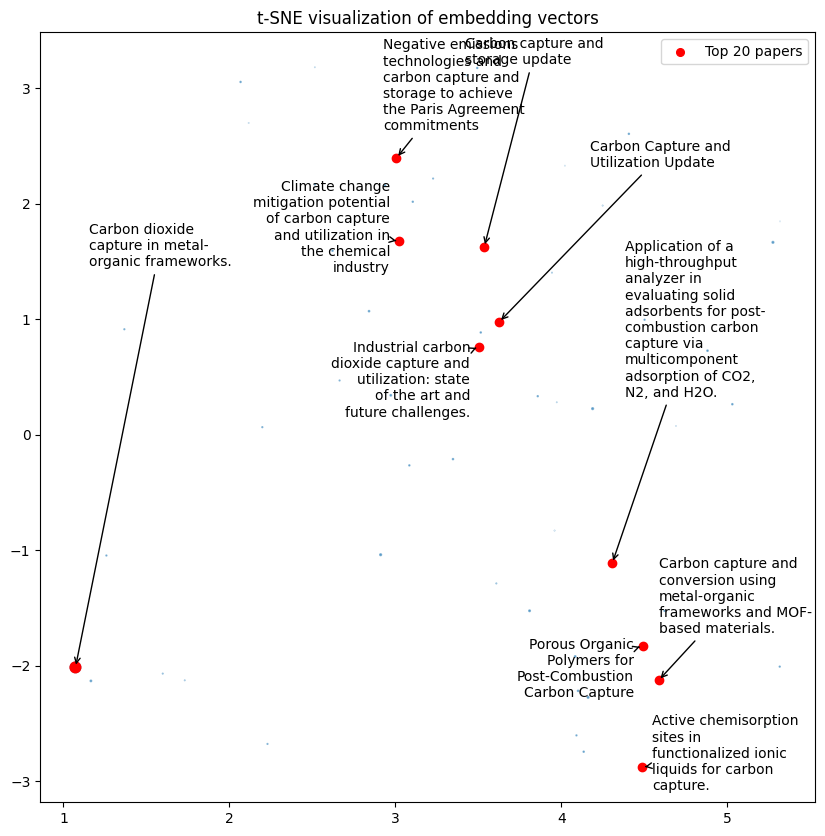

In [44]:
# # Working implementation of t-SNE?

# # Add the 2D t-SNE coordinates to the DataFrame and normalize citationCount for node sizes
# df['x'] = embeddings_2d[:, 0]
# df['y'] = embeddings_2d[:, 1]
# df['citationCount_normalized'] = (df['citationCount'] - df['citationCount'].min()) / (df['citationCount'].max() - df['citationCount'].min())
# df['citationCount_normalized'] = df['citationCount_normalized'] * len(df)  # Scale to a suitable range for scatter plot node sizes

# # Sort the DataFrame based on citationCount and select the top 20
# df_top20 = df.nlargest(10, 'citationCount')

# # Create a scatter plot of all the points with node sizes based on normalized citationCount
# plt.figure(figsize=(10, 10))
# plt.scatter(df['x'], df['y'], s=df['citationCount_normalized'], alpha=0.5, label='All papers')

# # Highlight the top 20 papers in the plot with node sizes based on normalized citationCount
# top20_scatter = plt.scatter(df_top20['x'], df_top20['y'], s=df_top20['citationCount_normalized'], color='red')

# # Prepare to add titles of the top 20 papers to the plot with text wrapping
# texts = []
# for i, row in df_top20.iterrows():
#     title_wrapped = textwrap.fill(row['title'], width=20)  # Wrap text after 20 characters
#     plt.scatter(row['x'], row['y'], color='red')  # This will ensure the dot is above the line
#     texts.append(plt.annotate(title_wrapped, (row['x'], row['y']), textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->")))

# # Use adjust_text to automatically adjust the positions of the text labels
# adjust_text(texts)

# plt.title('t-SNE visualization of embedding vectors')
# plt.legend(handles=[top20_scatter], labels=['Top 20 papers'])
# plt.show()

In [49]:
# # attempting hierarchical clustering with LDA
# import pandas as pd
# from gensim.corpora import Dictionary
# from gensim.models import LdaModel
# from gensim.utils import simple_preprocess
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# # Download the set of stop words the first time
# import nltk
# nltk.download('stopwords')

# # Load the set of English stop words
# stop_words = set(stopwords.words('english'))

# # Assume that 'documents' is your list of documents. 
# # Each document is a string of words.

# # Preprocess your documents
# documents = df['abstract'].apply(simple_preprocess)

# # Tokenize the documents into words, convert to lower case, 
# # and remove stop words
# filtered_documents = []
# for doc in documents:
#     word_tokens = doc
#     filtered_document = [word for word in word_tokens if word not in stop_words]
#     filtered_documents.append(filtered_document)

# # Create a gensim dictionary from the documents
# dictionary = Dictionary(filtered_documents)

# # Create a corpus for LDA
# corpus = [dictionary.doc2bow(doc) for doc in documents]

# # Fit an LDA model
# lda = LdaModel(corpus, num_topics=20, id2word=dictionary, alpha='auto', eta='auto')

# # Print the top words for each topic
# for i in range(10):
#     print(f"Topic {i+1}:")
#     print([dictionary[word_id] for word_id, prob in lda.get_topic_terms(i, topn=10)])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1kevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1:
['co', 'capture', 'carbon', 'mof', 'capacity', 'gas', 'adsorption', 'organic', 'metal', 'lca']
Topic 2:
['co', 'capture', 'ccs', 'carbon', 'storage', 'current', 'development', 'technologies', 'potential', 'materials']
Topic 3:
['co', 'carbon', 'capture', 'ccs', 'emissions', 'beccs', 'storage', 'gas', 'climate', 'mof']
Topic 4:
['co', 'capture', 'carbon', 'storage', 'energy', 'system', 'ccs', 'technologies', 'production', 'biomass']
Topic 5:
['co', 'carbon', 'capture', 'ccs', 'gas', 'potential', 'based', 'storage', 'emissions', 'cost']
Topic 6:
['capture', 'co', 'carbon', 'cost', 'ionic', 'liquids', 'containing', 'site', 'chemical', 'global']
Topic 7:
['co', 'carbon', 'capture', 'screening', 'new', 'climate', 'ccs', 'performance', 'materials', 'review']
Topic 8:
['carbon', 'co', 'biomass', 'capture', 'low', 'lca', 'capacity', 'emissions', 'technologies', 'high']
Topic 9:
['co', 'carbon', 'capture', 'gas', 'adsorption', 'corrosion', 'chemical', 'stability', 'emissions', 'based']

In [35]:
# Get the topic-document distribution from the LDA model
topic_dist = [lda.get_document_topics(bow, minimum_probability=0) for bow in corpus]

# Convert the topic distributions to a 2D array
topic_dist_array = np.zeros((len(corpus), lda.num_topics))
for i in range(len(corpus)):
    for topic, prob in topic_dist[i]:  # topic_dist[i] is a list of tuples
        topic_dist_array[i, topic] = prob  # topic is an integer (the topic ID)

# Perform hierarchical clustering on the topic-document distribution
cluster = AgglomerativeClustering(n_clusters=5)
cluster_labels = cluster.fit_predict(topic_dist_array)

In [38]:
print(topic_dist)

[[(0, 0.079126924), (1, 0.00018889569), (2, 0.00018889569), (3, 0.00018889569), (4, 0.00018889569), (5, 0.00018889569), (6, 0.00018889569), (7, 0.00018889569), (8, 0.00018889569), (9, 0.00018889569), (10, 0.00018889569), (11, 0.00018889569), (12, 0.00018889569), (13, 0.9174729), (14, 0.00018889569), (15, 0.00018889569), (16, 0.00018889569), (17, 0.00018889569), (18, 0.00018889569), (19, 0.00018889569)], [(0, 0.00029949818), (1, 0.99430954), (2, 0.00029949818), (3, 0.00029949818), (4, 0.00029949818), (5, 0.00029949818), (6, 0.00029949818), (7, 0.00029949818), (8, 0.00029949818), (9, 0.00029949818), (10, 0.00029949818), (11, 0.00029949818), (12, 0.00029949818), (13, 0.00029949818), (14, 0.00029949818), (15, 0.00029949818), (16, 0.00029949818), (17, 0.00029949818), (18, 0.00029949818), (19, 0.00029949818)], [(0, 0.9965445), (1, 0.00018186746), (2, 0.00018186746), (3, 0.00018186746), (4, 0.00018186746), (5, 0.00018186746), (6, 0.00018186746), (7, 0.00018186746), (8, 0.00018186746), (9, 0.0

In [36]:
# Use t-SNE for visualization
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(topic_dist)

# Create a scatter plot of the embeddings, colored by cluster label
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels)
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Print the top 10 words for each topic
for i in range(lda.num_topics):
    print(f"Topic {i}:")
    for word, prob in lda.show_topic(i, topn=10):
        print(f"  {word}: {prob}")
